## ライブラリのインポート

In [1]:
import numpy as np
# アイリスの計測データ
from sklearn.datasets import load_iris
# 訓練データと検証データの分割
from sklearn.model_selection import train_test_split
# データを扱う
import pandas as pd
# 予測結果の精度表示
from sklearn import metrics
# グラフ描画
from matplotlib import pyplot as plt
import japanize_matplotlib

C:\Users\takasaki\Anaconda3\envs\matplotlib\lib\site-packages\japanize_matplotlib\japanize_matplotlib.py:15: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


In [2]:
import torch
# 自動微分の関数 
from torch.autograd import Variable
# ニューラルネットワークの関数
import torch.nn as nn
# 活性化関数
import torch.nn.functional as F
# 最適化のアルゴリズムの関数
import torch.optim as optim
#ユーティリティのデータから
from torch.utils.data import DataLoader ,TensorDataset, Dataset

# テスト用データの読み込み

In [157]:
class IrisDataset(Dataset):
    def __init__(self, testsize=0.2):
        iris = load_iris()
        X=iris.data
        
        self.target = iris.target
        Y = np.zeros((len(iris.target), 1 + iris.target.max()), dtype=int)
        Y[np.arange(len(iris.target)), iris.target] = 1
        
        # 訓練データと検証データに分割する
        X_train,X_test,Y_train,Y_test=train_test_split(X, Y, test_size=testsize, random_state=1) 
        
        # テンソルに変換
        self.X_data = torch.FloatTensor(X_train)
        self.X_test = torch.FloatTensor(X_test)
        self.Y_data = torch.FloatTensor(Y_train)
        self.Y_test = torch.FloatTensor(Y_test)
        self.X_fulldata = torch.FloatTensor(X)
        self.Y_fulldata = torch.FloatTensor(Y)
        
        self.datalen = len(self.Y_data)
        self.in_size = self.X_data.shape[1]
        self.out_size = self.Y_data.shape[1]
        print('X_size=', self.in_size)
        print('Y_size=', self.out_size)
        print('record_cnt=', self.datalen)
        
    def __getitem__(self, index):
        return self.X_data[index], self.Y_data[index]
    
    def __len__(self):
        return self.datalen

In [158]:
Batch_size = 20
dataset = IrisDataset()
trainloader = DataLoader(dataset=dataset, batch_size = Batch_size, shuffle=True)

X_size= 4
Y_size= 3
record_cnt= 120


# ニューラルネットワークの定義

ニューラルネットワークのノード数や階層を定義する \
出力値を求める関数を定義する（ノード数によって変わる、求めたい値によっても変わる）

In [136]:
# Module を継承して、Netクラスを作成する
#  ノード数や階層を増やす　⇒　精度が向上する、学習のパフォーマンスは落ちる
#  ノード数や階層を減らす　⇒　精度が下がる、学習のパフォーマンスは上がる
#   　ノードや階層を変更しても精度が上がらない　⇒　入力データが不足している
class Net(nn.Module):
    # 初期化の関数
    def __init__(self, in_features, out_features, h1=10, h2=8):
        super(Net ,self).__init__()
        #   中間層のノード数は、精度向上やパフォーマンス向上を狙って調整する
        self.fc1 = nn.Linear(in_features , h1)         # nn.Linear (入力のノード数 , 中間層ノード数)
        self.fc2 = nn.Linear(h1, h2)                   # nn.Linear (中間層ノード数 , 中間層ノード数)
        self.fc3 = nn.Linear(h2, out_features)         # nn.Linear (中間層ノード数 , 出力のノード数)
        
    # ネットワークを通して、出力値を求める関数
    def forward(self ,x):
        x = F.relu(self.fc1(x))              # 入力のノードを中間層（１階層目）に渡して結果を得る
        x = F.relu(self.fc2(x))              # 中間層（１階層目）の結果を中間層（２階層目）に渡して結果を得る
        x = self.fc3(x)                      # 中間層（２階層目）の結果を出力層に渡す
        # dim　:求めたい確率の値　今回は１になる確率
        return F.log_softmax(x , dim=1)

# 学習する

In [142]:
# モデルの定義
model = Net(in_features = dataset.in_size, out_features = dataset.out_size)
# 損失の定義 (平均二乗誤差)
criterion = nn.MSELoss()

In [143]:
# 最適化のアルゴリズムの選択　（確率的勾配効果法（SGD：Stochastic Gradient Descent）
## model.parameters  調整する値
## lr(learning rate) ：学習率　どれぐらいの幅でパラメータを更新していくのか
optimizer = optim.SGD(model.parameters() , lr=0.01)

In [144]:
loss_list = []
loss_temp = 0

epochs=500
logdisp=20

accuracy_list = []

correct_counter = 0
acccnt=len(dataset)*logdisp

# トレーニングの回数分ループする。
for epoch in range(epochs):
    # 損失を初期化　
    total_loss = 0
    
    # データの件数分ループする。（x_train , y_train　に１レコードずつ格納される）
    for x_train , y_train in trainloader:
        # Variable ：　torch,autograd.Variable  ：テンソルをwrapして計算操作を記録する
        x_train ,y_train = Variable(x_train) ,Variable(y_train)
        # 出力を計算する 
        output = model(x_train)
        # 損失の計算 (出力の結果；output と 正解：y_trainを渡す)
        loss = criterion(output ,y_train)
        y_pred = torch.max(output.data, axis=1)[1]
        t_true = torch.max(y_train.data, axis=1)[1]

        correct_temp = (t_true == y_pred).sum()
        correct_counter += correct_temp
        
        # パラメータの勾配を初期化する
        optimizer.zero_grad()
        # ロスを伝播する
        loss.backward()
        # パラメータを更新する
        optimizer.step()
        # トータルロスを格納
        total_loss += loss.item()
        
    # 10回毎に回数とトータルロスを表示する
    if (epoch+1)%logdisp == 0:
        loss_tmp=total_loss/acccnt
        print(f'Epoch\t{epoch+1}\t\tLoss\t{loss_tmp:.8f}\t\taccuracy:\t{(correct_counter*100)/acccnt:.3f}%')
        
        accuracy_list.append(correct_counter.item()*100/(acccnt))
        loss_list.append(loss_tmp)
        loss_temp=0
        total_loss=0
        correct_counter = 0
        

Epoch	20		Loss	0.00558964		accuracy:	54.000%
Epoch	40		Loss	0.00555402		accuracy:	89.000%
Epoch	60		Loss	0.00554392		accuracy:	87.000%
Epoch	80		Loss	0.00553907		accuracy:	87.000%
Epoch	100		Loss	0.00553530		accuracy:	89.000%
Epoch	120		Loss	0.00553163		accuracy:	90.000%
Epoch	140		Loss	0.00552751		accuracy:	92.000%
Epoch	160		Loss	0.00552319		accuracy:	93.000%
Epoch	180		Loss	0.00551858		accuracy:	94.000%
Epoch	200		Loss	0.00551392		accuracy:	96.000%
Epoch	220		Loss	0.00550928		accuracy:	96.000%
Epoch	240		Loss	0.00550484		accuracy:	96.000%
Epoch	260		Loss	0.00550107		accuracy:	96.000%
Epoch	280		Loss	0.00549790		accuracy:	96.000%
Epoch	300		Loss	0.00549506		accuracy:	96.000%
Epoch	320		Loss	0.00549273		accuracy:	96.000%
Epoch	340		Loss	0.00549125		accuracy:	97.000%
Epoch	360		Loss	0.00548949		accuracy:	97.000%
Epoch	380		Loss	0.00548885		accuracy:	96.000%
Epoch	400		Loss	0.00548784		accuracy:	97.000%
Epoch	420		Loss	0.00548694		accuracy:	97.000%
Epoch	440		Loss	0.00548677		accuracy:	

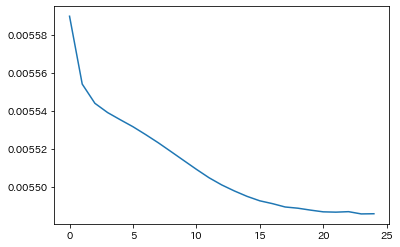

In [145]:
# ロスのプロット
plt.plot(loss_list)

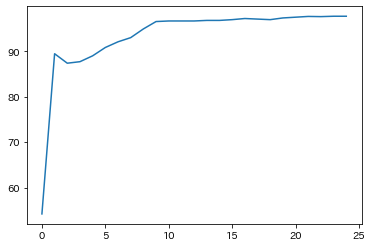

In [146]:
plt.plot(accuracy_list)

## 誤差の確認

In [147]:
# 学習を行わないモードに変更
model.eval()

# テストデータ
x_test ,y_test = Variable(dataset.X_test) ,Variable(dataset.Y_test)
# テストデータｘに対する結果　（値の大きい方を取得する）
y_hat = torch.max(model(x_test).data ,1)[1]
# 正解データは形を変えているので、元に戻す
y_true = np.argmax(y_test, axis=1)
# テストｘの結果とｙの比較　（結果が一致したら加算して、不一致は加算しない。その結果をデータ数で割る）
accuracy = np.sum(y_true.numpy() == y_hat.numpy()) /len(y_test.data)

In [148]:
# 正解データ
y_true.numpy()

array([0, 1, 1, 0, 2, 1, 2, 0, 0, 2, 1, 0, 2, 1, 1, 0, 1, 1, 0, 0, 1, 1,
       1, 0, 2, 1, 0, 0, 1, 2], dtype=int64)

In [149]:
# 予測値
y_hat.numpy()

array([0, 1, 1, 0, 2, 1, 2, 0, 0, 2, 1, 0, 2, 1, 1, 0, 1, 1, 0, 0, 1, 1,
       1, 0, 2, 1, 0, 0, 1, 2], dtype=int64)

In [150]:
# 予測値の正解率
accuracy

1.0

In [151]:
y_hat_numpy = y_hat.numpy()
print(metrics.classification_report(y_true.numpy(),y_hat.numpy() ))  # 正解率など
print('-----')
print(metrics.confusion_matrix(y_true.numpy(), y_hat.numpy() ))     # 行:正解、列:予測

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00         6

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

-----
[[11  0  0]
 [ 0 13  0]
 [ 0  0  6]]


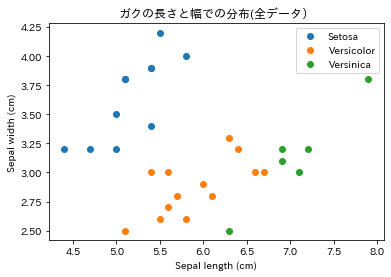

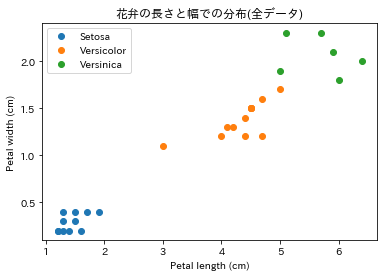

In [152]:
#予測結果を格納
st_predict_sepal = [[],[]]  # Setosa
st_predict_petal = [[],[]]  # Setosa
vc_predict_sepal = [[],[]]   # Versicolor
vc_predict_petal = [[],[]]   # Versicolor
vn_predict_sepal = [[],[]]   # Versinica
vn_predict_petal = [[],[]]   # Versinica
i = 0
# 予測値に対してデータを分割
for _y_hat in y_hat.numpy():
    if _y_hat == 0:
        st_predict_sepal[0].append(dataset.X_test[i][0])
        st_predict_sepal[1].append(dataset.X_test[i][1])
        st_predict_petal[0].append(dataset.X_test[i][2])
        st_predict_petal[1].append(dataset.X_test[i][3])
    elif _y_hat == 1:
        vc_predict_sepal[0].append(dataset.X_test[i][0])
        vc_predict_sepal[1].append(dataset.X_test[i][1])
        vc_predict_petal[0].append(dataset.X_test[i][2])
        vc_predict_petal[1].append(dataset.X_test[i][3])
    elif _y_hat == 2:
        vn_predict_sepal[0].append(dataset.X_test[i][0])
        vn_predict_sepal[1].append(dataset.X_test[i][1])
        vn_predict_petal[0].append(dataset.X_test[i][2])
        vn_predict_petal[1].append(dataset.X_test[i][3])
    else:
        continue
    i += 1

plt.scatter(st_predict_sepal[0], st_predict_sepal[1], label="Setosa")      # Sepal lengthとSepal width
plt.scatter(vc_predict_sepal[0], vc_predict_sepal[1], label="Versicolor")  # Sepal lengthとSepal width
plt.scatter(vn_predict_sepal[0], vn_predict_sepal[1], label="Versinica")  # Sepal lengthとSepal width
plt.legend()
plt.title('ガクの長さと幅での分布(全データ）')
plt.xlabel("Sepal length (cm)")    # ガクの長さ
plt.ylabel("Sepal width (cm)")     # ガクの幅
plt.show()

plt.scatter(st_predict_petal[0], st_predict_petal[1], label="Setosa")      # Petal lengthとPetal width
plt.scatter(vc_predict_petal[0], vc_predict_petal[1], label="Versicolor")  # Petal lengthとPetal width
plt.scatter(vn_predict_petal[0], vn_predict_petal[1], label="Versinica")   # Petal lengthとPetal width
plt.legend()
plt.title('花弁の長さと幅での分布(全データ)')
plt.xlabel("Petal length (cm)")   # 花弁の長さ
plt.ylabel("Petal width (cm)")    # 花弁の幅
plt.show()

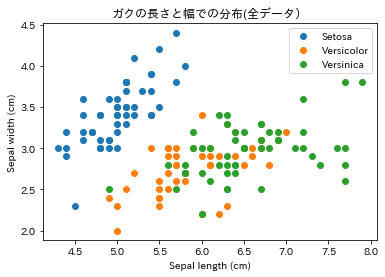

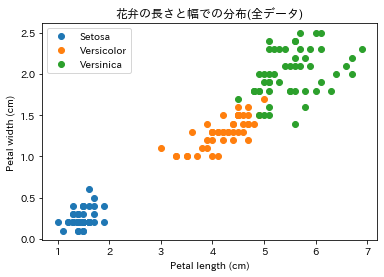

In [153]:
y_hat2 = torch.max(model(dataset.X_fulldata) ,1)[1]

#予測結果を格納
st_predict_sepal = [[],[]]  # Setosa
st_predict_petal = [[],[]]  # Setosa
vc_predict_sepal = [[],[]]   # Versicolor
vc_predict_petal = [[],[]]   # Versicolor
vn_predict_sepal = [[],[]]   # Versinica
vn_predict_petal = [[],[]]   # Versinica
i = 0
# 予測値に対してデータを分割
for _y_hat in y_hat2.numpy():
    if _y_hat == 0:
        st_predict_sepal[0].append(dataset.X_fulldata[i][0])
        st_predict_sepal[1].append(dataset.X_fulldata[i][1])
        st_predict_petal[0].append(dataset.X_fulldata[i][2])
        st_predict_petal[1].append(dataset.X_fulldata[i][3])
    elif _y_hat == 1:
        vc_predict_sepal[0].append(dataset.X_fulldata[i][0])
        vc_predict_sepal[1].append(dataset.X_fulldata[i][1])
        vc_predict_petal[0].append(dataset.X_fulldata[i][2])
        vc_predict_petal[1].append(dataset.X_fulldata[i][3])
    elif _y_hat == 2:
        vn_predict_sepal[0].append(dataset.X_fulldata[i][0])
        vn_predict_sepal[1].append(dataset.X_fulldata[i][1])
        vn_predict_petal[0].append(dataset.X_fulldata[i][2])
        vn_predict_petal[1].append(dataset.X_fulldata[i][3])
    else:
        continue
    i += 1

plt.scatter(st_predict_sepal[0], st_predict_sepal[1], label="Setosa")      # Sepal lengthとSepal width
plt.scatter(vc_predict_sepal[0], vc_predict_sepal[1], label="Versicolor")  # Sepal lengthとSepal width
plt.scatter(vn_predict_sepal[0], vn_predict_sepal[1], label="Versinica")  # Sepal lengthとSepal width
plt.legend()
plt.title('ガクの長さと幅での分布(全データ）')
plt.xlabel("Sepal length (cm)")    # ガクの長さ
plt.ylabel("Sepal width (cm)")     # ガクの幅
plt.show()

plt.scatter(st_predict_petal[0], st_predict_petal[1], label="Setosa")      # Petal lengthとPetal width
plt.scatter(vc_predict_petal[0], vc_predict_petal[1], label="Versicolor")  # Petal lengthとPetal width
plt.scatter(vn_predict_petal[0], vn_predict_petal[1], label="Versinica")   # Petal lengthとPetal width
plt.legend()
plt.title('花弁の長さと幅での分布(全データ)')
plt.xlabel("Petal length (cm)")   # 花弁の長さ
plt.ylabel("Petal width (cm)")    # 花弁の幅
plt.show()

In [159]:
print(metrics.classification_report(dataset.target , y_hat2.numpy() ))  # 正解率など
print('-----')
print(metrics.confusion_matrix(dataset.target, y_hat2.numpy() ))     # 行:正解、列:予測

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      0.94      0.97        50
           2       0.94      1.00      0.97        50

    accuracy                           0.98       150
   macro avg       0.98      0.98      0.98       150
weighted avg       0.98      0.98      0.98       150

-----
[[50  0  0]
 [ 0 47  3]
 [ 0  0 50]]


## 予測する

In [166]:
def print_predict(_x , _y):
    print('入力データ',_x)
    y_predict = model(_x).data
    print('予測値(確率)',y_predict)
    print('予測値',torch.max(y_predict ,1)[1])
    print('正解',_y)

In [167]:
# 全データの１件目　　：　Setosa
print_predict(dataset.X_fulldata[0:1] , dataset.target[0:1])

入力データ tensor([[5.1000, 3.5000, 1.4000, 0.2000]])
予測値(確率) tensor([[-0.8338, -1.2783, -1.2479]])
予測値 tensor([0])
正解 [0]


In [168]:
# 全データの５１件目：　Versicolor
print_predict(dataset.X_fulldata[51:52] , dataset.target[51:52])

入力データ tensor([[6.4000, 3.2000, 4.5000, 1.5000]])
予測値(確率) tensor([[-1.2412, -0.8819, -1.2141]])
予測値 tensor([1])
正解 [1]


In [169]:
# 全データの１０１件目　　：　Versinica
print_predict(dataset.X_fulldata[101:102] , dataset.target[101:102])

入力データ tensor([[5.8000, 2.7000, 5.1000, 1.9000]])
予測値(確率) tensor([[-1.2486, -1.2031, -0.8848]])
予測値 tensor([2])
正解 [2]
